In [1]:
from datetime import date
import yfinance as yf
import pandas as pd
import numpy as np
import warnings
import matplotlib as plt


# Suppress future warnings
warnings.filterwarnings('ignore', category=FutureWarning)

# 1. Introduction



In [2]:
stock_ticker = 'MSFT'

# 2. Fetching the Data
Typically, the `yfinance` module can go back as far back in time as the historical data of a stock in the market. For stocks like microsoft and Apple, this could mean over 35 years of data. This is not in itself a problem, except for the fact that in the models that we need to develop, we want to build in two exogeneous variables to help with predictions:
* The daily price of  TIP, which started trading on 5th December 2003.
* The Microsoft Earnings calls, which go back as far as 26th January 2015. These calls have taken place quarterly since the company first went public in 1986; however, the data for the estimated and actual earnings per share is not available on their site prior to 2015.


## 2.1. Extracting Daily Closing Prices for a TIPS

* The longest-running ETF that tracks Treasury Inflation-Protected Securities (TIPS) is the iShares TIPS Bond ETF (ticker: **TIP**).
* It was launched by BlackRock on December 4, 2003.

* This ETF aims to track the investment results of an index composed of inflation-protected U.S. Treasury bonds.
* It's one of the most well-known and widely traded TIPS ETFs, providing investors with exposure to inflation-protected bonds issued by the U.S. government.

In [3]:
# Choose the ticker symbol
inflation_ticker = 'TIP'

# Get data on this ticker
tickerData = yf.Ticker(inflation_ticker)

# Get the historical prices for this ticker
tip = tickerData.history(period="max")

# Extract the Closing Price only
tip = pd.DataFrame(tip['Close'])

# Rename the Close column for clarity
tip.rename(columns = {'Close': 'tip_price'}, inplace = True)

# Make the date index timezone-naive since the earnings call data will be as well
tip.index = [d.date() for d in tip.index.to_pydatetime()]
# Visualise
tip

,tip_price
2003-12-05,53.091007
2003-12-08,53.044117
2003-12-09,52.908569
2003-12-10,53.049316
2003-12-11,53.257820
...,...
2024-08-09,108.199997
2024-08-12,108.489998
2024-08-13,108.720001
2024-08-14,108.660004


### 2.1.1. Visualising the TIP data over time

<AxesSubplot:>

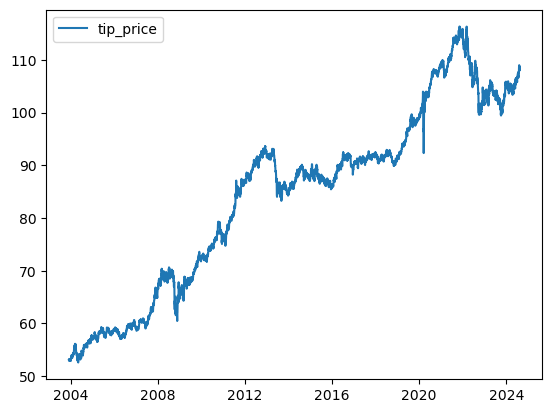

In [4]:
tip.plot()

## 2.2. Extracting the Data on Earnings Calls

The data on the Earnings Calls for Microsoft, including: their dates, the estimated Earnings-per-Share (EPS) and the Actual EPS, can be found on [this website](https://www.alphaquery.com/stock/MSFT/earnings-history).

In [6]:
import requests
import bs4

In [7]:
# # Install Selenium if not already
# pip install selenium
# !pip install webdriver-manager


In [8]:
# # Install chromium, its driver, and selenium
# !apt-get update
# !apt install -y chromium-chromedriver


In [9]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.chrome.service import Service

# Correct path to the ChromeDriver executable
service = Service(r'C:\Program Files\chromedriver-win64\chromedriver.exe')  # Replace with the actual path

driver = webdriver.Chrome(service=service)

# Define the URL
url = f'https://www.alphaquery.com/stock/{stock_ticker}/earnings-history'

# Navigate to the URL
driver.get(url)

# Wait for the page to fully load (you can adjust the sleep time if needed)
driver.implicitly_wait(10)

# Find the table element
table = driver.find_element(By.TAG_NAME, 'table')

# Extract the table rows
rows = table.find_elements(By.TAG_NAME, 'tr')

# Initialize a list to store the table data
table_data = []

# Loop through the rows and extract the data
for row in rows:
    cells = row.find_elements(By.TAG_NAME, 'td')
    cell_data = [cell.text for cell in cells]
    table_data.append(cell_data)

# Close the WebDriver
driver.quit()

# Convert the data to a pandas DataFrame
earnings_calls = pd.DataFrame(table_data)

# Now let's reformat the df for it to be meaningful
earnings_calls.drop(0, inplace = True) # The first row is an empty artefact of the scraping and should be removed
# Next we will sort through the date so that the ascending order matches
# the order of the Price dataframe that will be generated by yfinance
earnings_calls.sort_values(by = 0, inplace = True)
earnings_calls.reset_index(drop=True, inplace=True) #Reset the index since we removed a row and resorted
earnings_calls.drop(1, axis = 1, inplace = True) #Removes column '1' as this is the Date of the Fiscal Quarter End that the Earnings Call relates to.
# We are looking at daily events and how they influence *future* prices, so this data is not relevant.

# Lets also rename the columns to their original ehadings
earnings_calls.rename(columns = {0: 'earnings_call_date', 2: "estimated_eps", 3: "actual_eps"}, inplace = True)


# Cast the Date column to a Datetime object since it will be easier when we want to merge dataframes 
# later with the yfinance data
earnings_calls['earnings_call_date'] = pd.to_datetime(earnings_calls['earnings_call_date'])
# We want to make them timezone-naive
earnings_calls['earnings_call_date'] = earnings_calls['earnings_call_date'].dt.date

#Let's sate the dates column as the index since it will match the format of the data imported by yfinance
earnings_calls.set_index('earnings_call_date', inplace = True)

# The estimated_eps and actual_eps columns are usually imported as strings preceded with a dollar sign '$'
# Let's remove the currency symbol and cast them as floats
earnings_calls['estimated_eps'] = earnings_calls['estimated_eps'].str.replace('$', '')
earnings_calls['estimated_eps'] = earnings_calls['estimated_eps'].astype(float)
earnings_calls['actual_eps'] = earnings_calls['actual_eps'].str.replace('$', '')
earnings_calls['actual_eps'] = earnings_calls['actual_eps'].astype(float)
# Display the DataFrame
earnings_calls


,estimated_eps,actual_eps
earnings_call_date,,
2015-01-26,0.70,0.77
2015-04-23,0.51,0.62
2015-07-21,0.56,0.62
2015-10-22,0.58,0.67
2016-01-28,0.69,0.78
2016-04-21,0.63,0.62
2016-07-19,0.58,0.69
2016-10-20,0.68,0.76
2017-01-26,0.79,0.83


*** comment

<AxesSubplot:xlabel='earnings_call_date'>

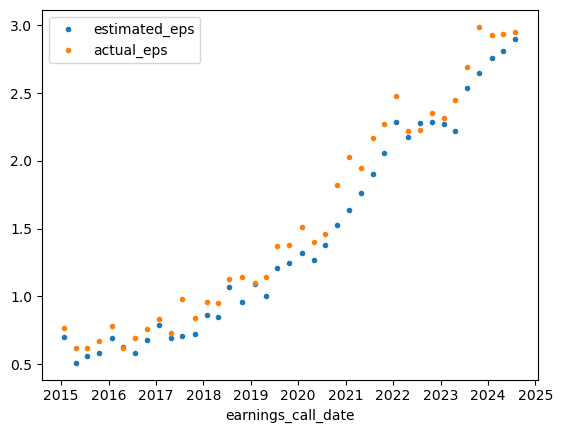

In [10]:
earnings_calls.plot(style = '.',
                   )
# plt.show()

We can observe the following:
* There is an upward trend in the actual earnings per share over the years.
* The difference between the actual and the estimated earnings per share over the years remains small
* The actual earnings per share tends to always be greater than the estimated.

## 2.3. Extracting the Daily Closing Prices on MSFT
Just like we did for **TIP**, we will use the `yfinance` module to extract historical data on daily closing prices for the stock that we loaded on the 1st cell.

In [11]:
# Get data on this ticker
tickerData = yf.Ticker(stock_ticker) # Loads the financial data on whatever stock ticker we loaded on cell 1

# Get the historical prices for this ticker
stock = tickerData.history(period="max")
# Extract the Closing Price only
stock = pd.DataFrame(stock['Close'])

# Rename the Close column for clarity
stock.rename(columns = {'Close': 'stock_price'}, inplace = True)

# Make the date index timezone-naive since the earnings call data will be as well
stock.index = [d.date() for d in stock.index.to_pydatetime()]

# Visualise
stock

,stock_price
1986-03-13,0.060055
1986-03-14,0.062199
1986-03-17,0.063272
1986-03-18,0.061663
1986-03-19,0.060591
...,...
2024-08-09,406.019989
2024-08-12,406.809998
2024-08-13,414.010010
2024-08-14,416.859985


*** comment

<AxesSubplot:>

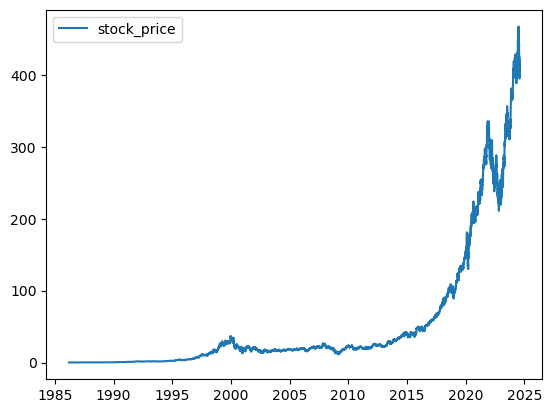

In [12]:
stock.plot()

### 2.1.2. Comparing the Stock and Inflation Tracker (TIP) prices over time

Text(0, 0.5, 'Inflation Tracker (TIP) Closing Stock Price - USD')

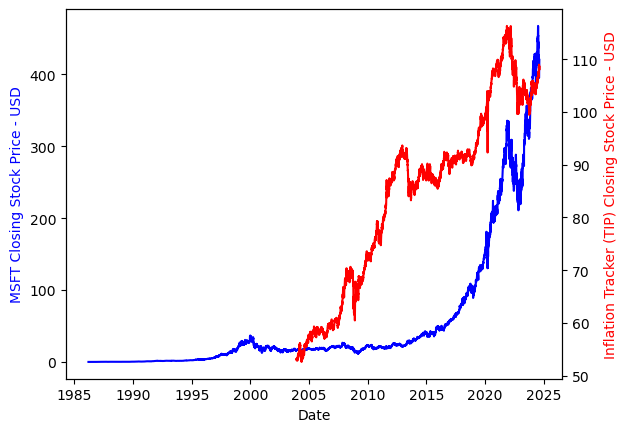

In [13]:
import matplotlib.pyplot as plt
fig, ax1 = plt.subplots()

stock_plot = ax1.plot(stock.index, 
                      stock,
                      label = f'{stock_ticker} price over time',
                     color = 'b')
# Then we instantiate the second axis - ax2 - to share the same axis as the first one - ax1
ax2 = ax1.twinx()

inflation_plot = ax2.plot(tip.index,
                          tip,
                          label = f'{inflation_ticker} price over time',
                     color = 'r')

ax1.set_xlabel('Date')
ax1.set_ylabel(f'{stock_ticker} Closing Stock Price - USD',
              color = 'b')
ax2.set_ylabel(f'Inflation Tracker ({inflation_ticker}) Closing Stock Price - USD',
              color = 'r')

## 2.4. Merging the Three Dataframes according to their Shared Timeline


Typically, the `yfinance` module can go back as far back in time as the historical data of a stock in the market. For stocks like microsoft and Apple, this could mean over 35 years of data. This is not in itself a problem, except for the fact that in the models that we need to develop, we want to build in two exogeneous variables to help with predictions:
* The daily price of a TIP, which started trading on 5th December 2003.
* The Microsoft Earnings calls, which go back as far as 26th January 2015. These calls have taken place quarterly since the company first went public in 1986; however, the data for the estimated and actual earnings per share is not available on their site prior to 2015.


In [14]:
def mindful_concatenator (stock_df, inflation_df, earnings_calls_df):
    # First thing we want to do is to only keep the data they have from their shared timelines
    # We will fetch the df that starts the latest and filter the others to start at that same date.
    latest_date = max(stock_df.index[0], inflation_df.index[0], earnings_calls_df.index[0])
    # Now that I have obtained the 'earliest' date they've got in common, I will filter them
    new_stock = stock[latest_date:] #Restrict
    new_tip = tip[latest_date:]
    new_ec = earnings_calls[latest_date:]
    # The inflation and stock dataframes should have the same trading dates - bar some market events that
    # might have required one of the two tickers to stop trading for a period of time.
    # In case this has happened, I will do an inner join to ensure they have the same trading dates.
    inflation_with_stock_dfs = pd.concat([new_tip, new_stock], axis = 1, join = 'inner')
    # The Earnings Calls data is different - these calls only happen quarterly, so I want there to be a null value
    # on any trading date which does not have an earnings call.
    combined_df = pd.concat([inflation_with_stock_dfs, new_ec], axis = 1, join = 'outer')
    # This would have generated a NaN on every trading date without an earnings call.
    return combined_df


In [15]:
final = mindful_concatenator(stock, tip, earnings_calls)

In [16]:
final

,tip_price,stock_price,estimated_eps,actual_eps
2015-01-26,89.041443,40.520863,0.7,0.77
2015-01-27,89.322296,36.771332,NaN,NaN
2015-01-28,89.665543,35.504246,NaN,NaN
2015-01-29,89.564140,36.211048,NaN,NaN
2015-01-30,90.211685,34.823288,NaN,NaN
...,...,...,...,...
2024-08-09,108.199997,406.019989,NaN,NaN
2024-08-12,108.489998,406.809998,NaN,NaN
2024-08-13,108.720001,414.010010,NaN,NaN
2024-08-14,108.660004,416.859985,NaN,NaN


In [17]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2406 entries, 2015-01-26 to 2024-08-15
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tip_price      2406 non-null   float64
 1   stock_price    2406 non-null   float64
 2   estimated_eps  39 non-null     float64
 3   actual_eps     39 non-null     float64
dtypes: float64(4)
memory usage: 94.0+ KB


### 2.4.1. Visualising the stock price and the inflation indicator together

<AxesSubplot:title={'center':'Price of MSFT vs. inflation tracker (TIP)'}>

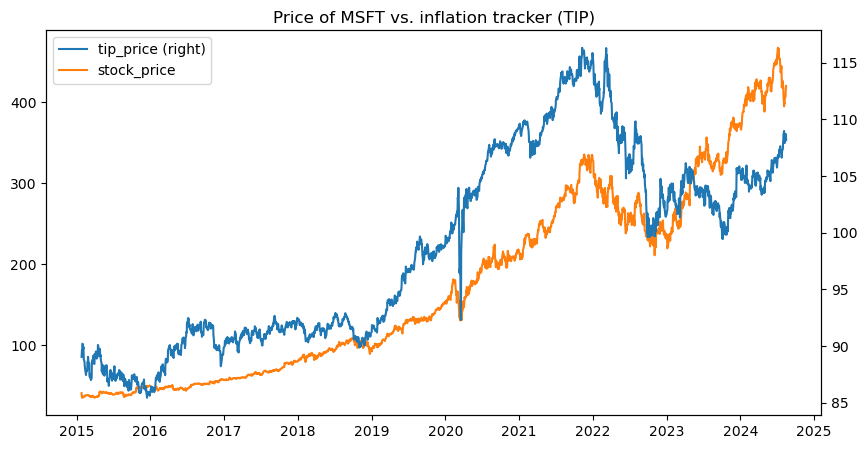

In [18]:
final.plot(y = ['tip_price', 'stock_price'],
           secondary_y = 'tip_price',
           figsize = (10, 5), # stretching out the plot sideways
           title = f'Price of {stock_ticker} vs. inflation tracker (TIP)',
               )

In [19]:
final.columns

Index(['tip_price', 'stock_price', 'estimated_eps', 'actual_eps'], dtype='object')

## 2.5. Feature Engineering
### 2.5.1. Create another column with the difference between the estimated and the actual earnigns per share.

In [20]:
final['eps_delta'] = final['actual_eps'] - final['estimated_eps']

final

,tip_price,stock_price,estimated_eps,actual_eps,eps_delta
2015-01-26,89.041443,40.520863,0.7,0.77,0.07
2015-01-27,89.322296,36.771332,NaN,NaN,NaN
2015-01-28,89.665543,35.504246,NaN,NaN,NaN
2015-01-29,89.564140,36.211048,NaN,NaN,NaN
2015-01-30,90.211685,34.823288,NaN,NaN,NaN
...,...,...,...,...,...
2024-08-09,108.199997,406.019989,NaN,NaN,NaN
2024-08-12,108.489998,406.809998,NaN,NaN,NaN
2024-08-13,108.720001,414.010010,NaN,NaN,NaN
2024-08-14,108.660004,416.859985,NaN,NaN,NaN


### 2.5.2. Create a categorical column with the outcome of the earnings call
*** When the actual earnings per share (EPS) is greater than the estimated EPS, it is typically referred to as an "earnings beat." This term indicates that the company has performed better than analysts or market expectations.

In [21]:
final['earnings_beat'] = final['eps_delta'].apply(lambda x: 1 if x > 0 else (-1 if x < 0 else np.nan))
final

,tip_price,stock_price,estimated_eps,actual_eps,eps_delta,earnings_beat
2015-01-26,89.041443,40.520863,0.7,0.77,0.07,1.0
2015-01-27,89.322296,36.771332,NaN,NaN,NaN,NaN
2015-01-28,89.665543,35.504246,NaN,NaN,NaN,NaN
2015-01-29,89.564140,36.211048,NaN,NaN,NaN,NaN
2015-01-30,90.211685,34.823288,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
2024-08-09,108.199997,406.019989,NaN,NaN,NaN,NaN
2024-08-12,108.489998,406.809998,NaN,NaN,NaN,NaN
2024-08-13,108.720001,414.010010,NaN,NaN,NaN,NaN
2024-08-14,108.660004,416.859985,NaN,NaN,NaN,NaN


*** value _counts

In [22]:
final.earnings_beat.value_counts()

 1.0    37
-1.0     2
Name: earnings_beat, dtype: int64

In [23]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2406 entries, 2015-01-26 to 2024-08-15
Data columns (total 6 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   tip_price      2406 non-null   float64
 1   stock_price    2406 non-null   float64
 2   estimated_eps  39 non-null     float64
 3   actual_eps     39 non-null     float64
 4   eps_delta      39 non-null     float64
 5   earnings_beat  39 non-null     float64
dtypes: float64(6)
memory usage: 131.6+ KB


## 2.6. Data Preprocessing
### 2.6.1. Converting the dataset into a supervised dataset

In [24]:
final['next_day_price'] = final['stock_price'].shift(-1)


In [25]:
final

,tip_price,stock_price,estimated_eps,actual_eps,eps_delta,earnings_beat,next_day_price
2015-01-26,89.041443,40.520863,0.7,0.77,0.07,1.0,36.771332
2015-01-27,89.322296,36.771332,NaN,NaN,NaN,NaN,35.504246
2015-01-28,89.665543,35.504246,NaN,NaN,NaN,NaN,36.211048
2015-01-29,89.564140,36.211048,NaN,NaN,NaN,NaN,34.823288
2015-01-30,90.211685,34.823288,NaN,NaN,NaN,NaN,35.581825
...,...,...,...,...,...,...,...
2024-08-09,108.199997,406.019989,NaN,NaN,NaN,NaN,406.809998
2024-08-12,108.489998,406.809998,NaN,NaN,NaN,NaN,414.010010
2024-08-13,108.720001,414.010010,NaN,NaN,NaN,NaN,416.859985
2024-08-14,108.660004,416.859985,NaN,NaN,NaN,NaN,420.420013


In [35]:
df = final.copy()

# Define the rolling window size
window_size = 3

# List to hold each rolled window
rolled_data = []

# Generate rolled windows
for i in range(len(df) - window_size):
    window = df.iloc[i:i + window_size]  # Get the rolling window
    rolled_data.append(window)           # Append it as-is (no flattening)

# Concatenate all the windows into a single DataFrame
rolled_df = pd.concat(rolled_data).reset_index(drop=True)

# Print the rolled DataFrame
print(rolled_df)

# Now split into X and y
# X will contain all rows except the last row of each original window
X = rolled_df.drop('next_day_price', axis=1)

# y will contain the 'next_day_price' from the last row of each original window
y = rolled_df.groupby(np.arange(len(rolled_df)) // window_size)['next_day_price'].last().reset_index(drop=True)

# Now, X and y are ready for model training
print(X)
print(y)


       tip_price  stock_price  estimated_eps  actual_eps  eps_delta  \
0      89.041443    40.520863            0.7        0.77       0.07   
1      89.322296    36.771332            NaN         NaN        NaN   
2      89.665543    35.504246            NaN         NaN        NaN   
3      89.322296    36.771332            NaN         NaN        NaN   
4      89.665543    35.504246            NaN         NaN        NaN   
...          ...          ...            ...         ...        ...   
7204  108.489998   406.809998            NaN         NaN        NaN   
7205  108.720001   414.010010            NaN         NaN        NaN   
7206  108.489998   406.809998            NaN         NaN        NaN   
7207  108.720001   414.010010            NaN         NaN        NaN   
7208  108.660004   416.859985            NaN         NaN        NaN   

      earnings_beat  next_day_price  
0               1.0       36.771332  
1               NaN       35.504246  
2               NaN       36.2110

In [39]:
df[:10]

,tip_price,stock_price,estimated_eps,actual_eps,eps_delta,earnings_beat,next_day_price
2015-01-26,89.041443,40.520863,0.7,0.77,0.07,1.0,36.771332
2015-01-27,89.322296,36.771332,NaN,NaN,NaN,NaN,35.504246
2015-01-28,89.665543,35.504246,NaN,NaN,NaN,NaN,36.211048
2015-01-29,89.564140,36.211048,NaN,NaN,NaN,NaN,34.823288
2015-01-30,90.211685,34.823288,NaN,NaN,NaN,NaN,35.581825
2015-02-02,90.149292,35.581825,NaN,NaN,NaN,NaN,35.857651
2015-02-03,89.735771,35.857651,NaN,NaN,NaN,NaN,36.064522
2015-02-04,89.923019,36.064522,NaN,NaN,NaN,NaN,36.590317
2015-02-05,89.532951,36.590317,NaN,NaN,NaN,NaN,36.555843
2015-02-06,88.830750,36.555843,NaN,NaN,NaN,NaN,36.512737


In [38]:
rolled_df[:15]

,tip_price,stock_price,estimated_eps,actual_eps,eps_delta,earnings_beat,next_day_price
0,89.041443,40.520863,0.7,0.77,0.07,1.0,36.771332
1,89.322296,36.771332,NaN,NaN,NaN,NaN,35.504246
2,89.665543,35.504246,NaN,NaN,NaN,NaN,36.211048
3,89.322296,36.771332,NaN,NaN,NaN,NaN,35.504246
4,89.665543,35.504246,NaN,NaN,NaN,NaN,36.211048
5,89.564140,36.211048,NaN,NaN,NaN,NaN,34.823288
6,89.665543,35.504246,NaN,NaN,NaN,NaN,36.211048
7,89.564140,36.211048,NaN,NaN,NaN,NaN,34.823288
8,90.211685,34.823288,NaN,NaN,NaN,NaN,35.581825
9,89.564140,36.211048,NaN,NaN,NaN,NaN,34.823288


In [31]:
X

,tip_price,stock_price,estimated_eps,actual_eps,eps_delta,earnings_beat
0,89.041443,40.520863,0.7,0.77,0.07,1.0
1,89.322296,36.771332,NaN,NaN,NaN,NaN
2,89.665543,35.504246,NaN,NaN,NaN,NaN
3,89.322296,36.771332,NaN,NaN,NaN,NaN
4,89.665543,35.504246,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...
7207,108.720001,414.010010,NaN,NaN,NaN,NaN
7208,108.660004,416.859985,NaN,NaN,NaN,NaN
7209,108.720001,414.010010,NaN,NaN,NaN,NaN
7210,108.660004,416.859985,NaN,NaN,NaN,NaN


In [32]:
y

0        36.211048
1        34.823288
2        35.581825
3        35.857651
4        36.064522
           ...    
2399    406.809998
2400    414.010010
2401    416.859985
2402    420.420013
2403    420.420013
Name: next_day_price, Length: 2404, dtype: float64

*** recodear lo de arriba y buscar standardisation

In [ ]:
# Pick the % of the dataset that we want to set aside for testing
pct_testing = 20

# Convert it into an index location in the input array for slicing
slicing_index = len(input_sequences) * pct_testing/100  #this makes a float so it needs to be casted onto an `int`
slicing_index = int(slicing_index)


# Slice the input and output sequences to separate training and test data
X_train = input_sequences[:-slicing_index]
y_train = output_sequences[:-slicing_index]
X_test = input_sequences[-slicing_index:]
y_test = output_sequences[-slicing_index:]

In [ ]:
list(final.columns.values).remove('actual_eps')

# 3. Define a Sliding Window
A sliding window of 66 days, as that is the average of trading days in between earnings calls. ***

In [ ]:
def sliding_window(input_df, window_length, supervised_col):
    # Initialize lists to store input and output sequences
    input_sequences = []
    output_sequences = []

    # Iterate through the data to create sequences
    for i in range(len(input_df) - window_length - 1):
        input_seq = input_df.iloc[i:i + window_length]  # This now includes both Price and EPS Ratio
        output_seq = input_df[supervised_col].iloc[i + window_length]  # for predicting the next day's price
        input_sequences.append(input_seq.values)  # Converts the DataFrame slice to a NumPy array
        output_sequences.append(output_seq)

    # Convert lists to NumPy arrays
    X = np.array(input_sequences)
    y = np.array(output_sequences)
    
    return X, y

In [ ]:
X, y = sliding_window(final, 66, 'next_day_price')

In [ ]:
X_pd = pd.DataFrame(X)
X_pd

In [ ]:
X

* Labour productivity - is there a daily index for this?